In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta

# sns.set( style = 'darkgrid' )

# Data Cleaning and Visualization

In [2]:
df = pd.read_csv( './Sensado_GYM_Completo.csv', encoding = 'ISO-8859-1', parse_dates = [ 'Fecha' ] )
df.columns = [ 'Date', 'Pre', 'Alt', 'Hum', 'Temp', 'Occ' ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10129 non-null  datetime64[ns]
 1   Pre     10129 non-null  float64       
 2   Alt     10129 non-null  float64       
 3   Hum     10125 non-null  float64       
 4   Temp    10129 non-null  float64       
 5   Occ     10129 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 474.9+ KB


## Filling null values

In [3]:
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     4
Temp    0
Occ     0
dtype: int64

In [4]:
df[ 'Hum' ].fillna( method ='ffill', inplace = True )
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     0
Temp    0
Occ     0
dtype: int64

In [5]:
# date format mm-dd-yyyy
# Fixing an error on the dates

temp = df[ ( df.Date >= '2019-01-01' ) & ( df.Date <= '2019-02' ) ][ 'Date' ] + timedelta( days = 264 )
df.loc[ temp.index, 'Date' ] = temp

## Visualization 

### Complete dataset

In [6]:
from scipy.stats import pearsonr

def pearson_corr( x, y, **kws ):
    ( r, p ) = pearsonr( x, y )
    ax = plt.gca()
    ax.annotate( "r = {:.2f} ".format( r ),
                xy = (.1, .9), xycoords = ax.transAxes )

def make_patch_spines_invisible( ax ):
    ax.set_frame_on( True )
    ax.patch.set_visible( False )
    for sp in ax.spines.values():
        sp.set_visible( False )
        
def plot_env_vars( x, temp, hum, occ, title = 'Temperature, Humidity and Occupancy' ):
    fig, host = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
    
    par1 = host.twinx()
    par2 = host.twinx()

    par2.spines[ 'right' ].set_position( ( 'axes', 1.04 ) )
    make_patch_spines_invisible( par2 )
    par2.spines[ 'right' ].set_visible( True )
    
    g1,  = host.plot( x, temp, 'royalblue', label = 'Temp' )
    g2,  = par1.plot( x, hum, 'forestgreen', label = 'Hum' )
    g3,  = par2.plot( x, occ.replace( { 'L': 0, 'M':1, 'H':2 } ), 'lightcoral', label = 'Occ' )
    
    host.set_xlabel( 'Date' )
    host.set_ylabel( 'Temp')
    par1.set_ylabel( 'Hum' )
    par2.set_ylabel( 'Occ' )
    
    par2.set_ylim( 0, 10 )
    par2.yaxis.set_major_locator( plt.IndexLocator( base = 1, offset = 0 ) )
    host.xaxis.set_major_locator( plt.AutoLocator() )
    
    plots = [ g1, g2, g3 ]
    host.legend( plots, [ l.get_label() for l in plots ] )
    
    fig.autofmt_xdate()
    plt.title( title )
    plt.show()
    
def plot_single( x, y, name ):
    fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
    
    g, = plt.plot( x, y, 'royalblue', label = name )
    
    ax.xaxis.set_major_locator( plt.AutoLocator() )
    ax.legend( [ g ], [ g.get_label() ] )
    ax.set_ylabel( name.capitalize() )
    
    fig.autofmt_xdate()
    plt.title( name.capitalize(), fontsize = 16 )
    plt.show()

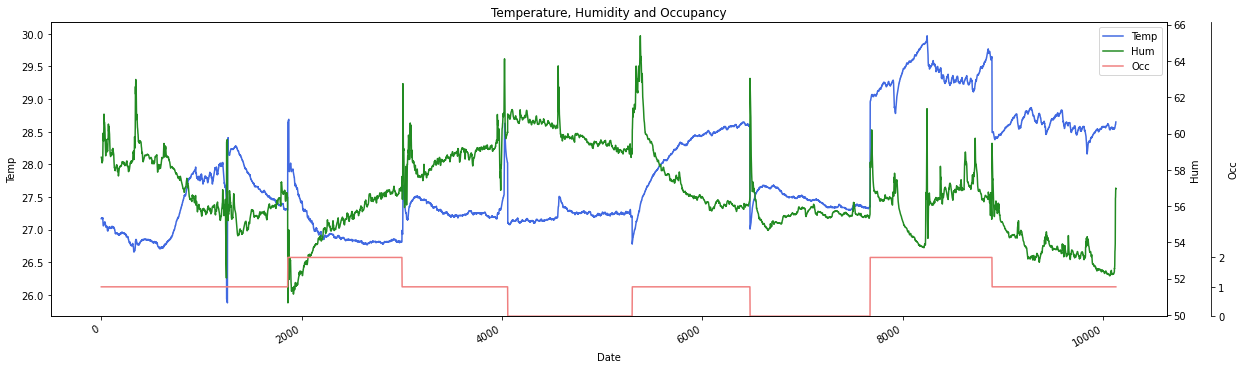

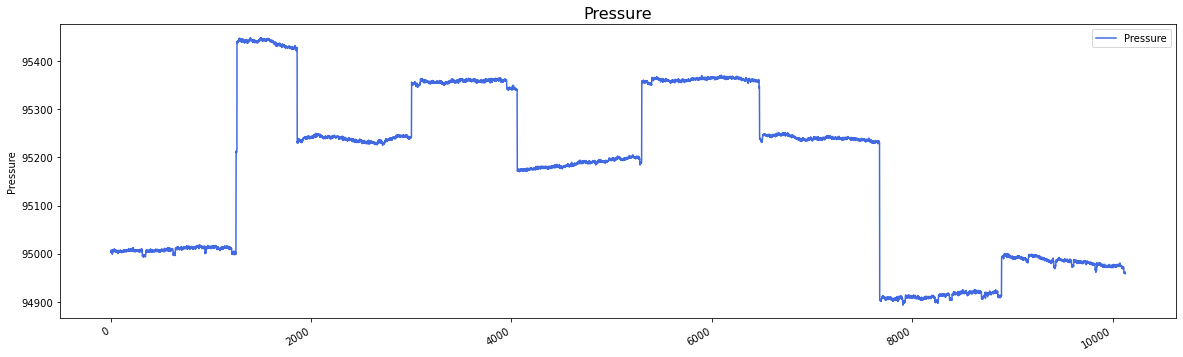

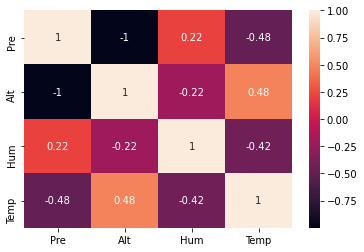

In [7]:
plot_env_vars( df.index, df[ 'Temp' ], df[ 'Hum' ], df[ 'Occ' ] )
plot_single( df.index, df[ 'Pre' ], 'Pressure' )
sns.heatmap( df.corr(), annot = True )

### By Day

In [8]:
df_temp = df.set_index( 'Date' ).resample( 'D' ).mean().dropna( how = 'any' )
df_temp.head( 50 )

,Pre,Alt,Hum,Temp
Date,,,,
2019-09-18,95008.449992,539.690016,57.736928,27.221200
2019-09-23,95306.477768,513.586958,55.216022,27.252038
2019-09-24,95071.054374,534.214876,56.129014,28.490017
2019-09-25,95239.831184,519.415755,55.598449,27.456422
2019-10-01,95361.285578,508.789821,57.533138,28.210349
2019-10-02,95186.726685,524.065776,60.022156,27.216251


In [9]:
from collections import Counter

df_temp = df.groupby( df.Date.dt.floor( 'D' ) ) 
for i, g in df_temp:
#     plot_env_vars( 
#         g.reset_index( drop = True ).index, 
#         g[ 'Temp' ], 
#         g[ 'Hum' ], 
#         g[ 'Occ' ],
#         "Temperature and Humidity (" + g.Date.iloc[ 0 ].strftime( '%Y-%b-%d' ) + ")" )
    
    print( Counter( g.Occ ) )

Counter({'M': 1250})
Counter({'H': 1141, 'M': 611})
Counter({'M': 2292, 'H': 1217})
Counter({'L': 1199})
Counter({'M': 1176})
Counter({'L': 1243})


# Preparing the Datasets

In [10]:
import enum

class DF( enum.Enum ):
    _OR = 0
    _10SEC = 1
    _1MIN = 2
    _5MIN = 3

AGG = [ 'mean' ]
dfs = { DF._OR: df, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }
grids = { 
    'svc': { DF._OR: None, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'knn': { DF._OR: None, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None },
    'dt': { DF._OR: None, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None } }

## Generating datasets with different resolution

### 10 seconds averaged

In [11]:
def agg_date( col ):
    return col.iloc[ 0 ] # left labeling

def agg_occupancy( col ): 
    return col.mode()[ 0 ]

def groupby_10( g, agg ):
    return g.groupby( np.arange( len( g ) ) // 10 ).agg( { 
        'Date': agg_date, 
        'Occ': agg_occupancy,
        'Pre': agg, 
        'Alt': agg, 
        'Hum': agg, 
        'Temp': agg } )


temp =  ( df.groupby( df.Date.dt.floor( 'D' ) )
    .apply( groupby_10, AGG )
    .reset_index( drop = True ) )

temp.columns = [ c[ 0 ] for c in temp.columns ]
temp = ( temp
    .rename( columns = { 'Date_agg_date': 'Date', 'Occ_agg_occupancy': 'Occ' } )
    .sort_values( by = 'Date' )
    .reset_index( drop = True ) )

dfs[ DF._10SEC ] = temp

### 1 minute

In [12]:
temp = ( df
    .set_index( 'Date' )
    .resample( '1 min' )
    .first()
    .dropna( axis = 0, how = 'any' )
    .reset_index() )

dfs[ DF._1MIN ] = temp

### 5 minutes

In [13]:
temp = ( df
    .set_index( 'Date' )
    .resample( '5 min' )
    .first()
    .dropna( axis = 0, how = 'any' )
    .reset_index() )

dfs[ DF._5MIN ] = temp

## Standarization

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_TRAIN = 0
X_TEST = 1
Y_TRAIN = 2
Y_TEST = 3

def standarize( df ):
    x_train, x_test, y_train, y_test = train_test_split( 
        df.drop( [ 'Occ', 'Date' ], axis = 1 ), 
        df.Occ, 
        test_size = .20, 
        random_state = 0 )
    
    scaler = StandardScaler()
    scaler.fit( x_train )

    x_train = scaler.transform( x_train )
    x_test = scaler.transform( x_test )
    
    return x_train, x_test, y_train, y_test

for k, d in dfs.items() : 
    x_train, x_test, y_train, y_test = standarize( d )
    dfs[ k ] = [ x_train, x_test, y_train, y_test ]

## Balancing classes

In [15]:
from imblearn.over_sampling import ADASYN
from collections import Counter

neighborgs = { DF._OR: 32, DF._10SEC: 32, DF._1MIN: 5, DF._5MIN: 3 }
for k, d in dfs.items() :   
    oversampler = ADASYN( 
        sampling_strategy = 'not majority', 
        n_neighbors = neighborgs[ k ], 
        random_state = 42 )
    
    x_train, y_train = oversampler.fit_resample( d[ X_TRAIN ], d[ Y_TRAIN ] )
    d[ X_TRAIN ] = x_train
    d[ Y_TRAIN ] = y_train
    print( k, Counter( y_train ) )

DF._OR Counter({'M': 4273, 'H': 4273, 'L': 4273})
DF._10SEC Counter({'H': 427, 'M': 425, 'L': 425})
DF._1MIN Counter({'H': 78, 'M': 77, 'L': 77})
DF._5MIN Counter({'L': 21, 'M': 21, 'H': 21})


# Features Selection

# Classification

In [16]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA



def grid_search( estimator, params ):
    scoring = 'accuracy'
    cv_method = RepeatedStratifiedKFold( n_splits = 10, n_repeats = 2, random_state = 0 )
    
    return GridSearchCV( 
        estimator = estimator,
        param_grid = params,
        cv = cv_method,
        verbose = False,
        scoring = scoring,
        return_train_score = True )


def train_and_test( estimator, params, x_train, y_train, 
                   x_test, y_test, plot_cmatrix = False ):
    
    grid = grid_search( estimator, params )
    
    # Training and evaluation

    grid.fit( x_train, y_train );
    print( 'Best params: ', grid.best_params_ )
    print( 'Training Accuracy', grid.best_score_ )

    y_pred = grid.best_estimator_.predict( x_test )
    print( 'Test Accuracy: ', accuracy_score( y_test, y_pred ) )
    
    if( plot_cmatrix ) :
        fig, ax = plt.subplots( 1, 1 )
        g = sns.heatmap( confusion_matrix( y_test, y_pred ), annot = True, cmap = "YlGnBu" )
        g.set_title( 'Test Confussion Matrix' )
    
    return grid

## Regular

### SVM

In [17]:
params_svc = [ { 
    'C': [ .1, 1, 10,  ], 
    'kernel': [ 'linear', 'poly' ] 
}, { 
    'C': [ .1, 1, 10 ], 
    'kernel': [ 'rbf' ],
    'gamma': [ 10, 1, 0.1 ]
} ]


print( '-----------------------------------' )
print( 'Regular datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    if( k != DF._OR ):
        print( 'Dataset ', k )
        train_and_test( 
                svm.SVC(), params_svc, 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
With different resolutions
-----------------------------------
Dataset  DF._10SEC
Best params:  {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.99921875
Test Accuracy:  0.9950738916256158
Dataset  DF._1MIN
Best params:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 1.0
Test Accuracy:  1.0
Dataset  DF._5MIN
Best params:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9142857142857143
Test Accuracy:  0.8888888888888888


### KNN

In [18]:
params_knn = [ { 
    'n_neighbors': [ 1, 3, 8, 13 ], 
    'p': [ 1, 2 ], # mikowsky distance
    'algorithm': [ 'brute', 'ball_tree', 'kd_tree' ]
} ]

print( '-----------------------------------' )
print( 'Regular datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( KNeighborsClassifier(), params_knn, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
With different resolutions
-----------------------------------
Dataset  DF._OR
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 1.0
Test Accuracy:  1.0
Dataset  DF._10SEC
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 0.99921875
Test Accuracy:  0.9950738916256158
Dataset  DF._1MIN
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 0.9957427536231883
Test Accuracy:  1.0
Dataset  DF._5MIN
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9309523809523809
Test Accuracy:  0.7777777777777778


### Decision Trees

In [19]:
params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ]
} ]

print( '-----------------------------------' )
print( 'Regular datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( DecisionTreeClassifier(), params_dt, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )

-----------------------------------
With different resolutions
-----------------------------------
Dataset  DF._OR
Best params:  {'criterion': 'gini', 'max_depth': 5}
Training Accuracy 1.0
Test Accuracy:  1.0
Dataset  DF._10SEC
Best params:  {'criterion': 'gini', 'max_depth': 5}
Training Accuracy 0.9980407234251969
Test Accuracy:  0.9950738916256158
Dataset  DF._1MIN
Best params:  {'criterion': 'entropy', 'max_depth': 8}
Training Accuracy 0.9893115942028985
Test Accuracy:  0.9722222222222222
Dataset  DF._5MIN
Best params:  {'criterion': 'gini', 'max_depth': 7}
Training Accuracy 0.8964285714285714
Test Accuracy:  0.7777777777777778


## PCA

In [ ]:
def add_pca_estimator( estimator ):
    return Pipeline( [ ( 'reduce_dim', PCA( .95 ) ),  ( 'clf', estimator ) ] )
    
def prefix_params( d_list, prefix ):
    result = []
    for d in d_list: 
        temp = {}
        for key in d.keys():
            temp[ prefix + '__' + key ] = d[ key ]
        result.append( temp )
    return result

### SVM

In [ ]:
print( '-----------------------------------' )
print( 'PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    if( k != DF._OR ): # the original dataset does not converge
        print( 'Dataset ', k )
        grids[ 'svc' ][ k ] = train_and_test( 
                add_pca_estimator( svm.SVC() ), 
                prefix_params( params_svc, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

### KNN

In [ ]:
print( '-----------------------------------' )
print( 'PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'knn' ][ k ] = train_and_test( 
                add_pca_estimator( KNeighborsClassifier() ), 
                prefix_params( params_knn, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

### Decision Trees

In [ ]:
print( '-----------------------------------' )
print( 'Testing with PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'dt' ][ k ] = train_and_test( 
        add_pca_estimator( DecisionTreeClassifier() ), 
        prefix_params( params_dt, 'clf' ), 
        df[ X_TRAIN ], df[ Y_TRAIN ], 
        df[ X_TEST ], df[ Y_TEST ] )

# Evaluation

## Learning Curves Analysis

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

def plot_learning_curve( estimator, title, X, y, axes = None, ylim = None, cv = None,
                        n_jobs = None, train_sizes = np.linspace( .1, 1.0, 5 ) ):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim( *ylim )
    axes[0].set_xlabel( 'Training examples' )
    axes[0].set_ylabel( 'Score' )

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve( estimator, X, y, cv = cv, n_jobs = n_jobs,
                       train_sizes = train_sizes,
                       return_times = True )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    
    axes[0].grid()
    axes[0].fill_between( train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha = 0.1,
                         color = 'r')
    axes[0].fill_between( train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1,
                         color = 'g' )
    
    axes[0].plot( train_sizes, train_scores_mean, 'o-', color = 'r',
                 label = 'Training score' )
    axes[0].plot( train_sizes, test_scores_mean, 'o-', color = 'g',
                 label = 'Cross-validation score' )
    axes[0].legend( loc = 'best' )

    
    # Plot n_samples vs fit_times
    
    axes[1].grid()
    axes[1].plot( train_sizes, fit_times_mean, 'o-' )
    axes[1].fill_between( train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha = 0.1 )
    axes[1].set_xlabel( 'Training examples' )
    axes[1].set_ylabel( 'fit_times' )
    axes[1].set_title( 'Scalability of the model' )
    
    
    # Plot fit_time vs score
    
    axes[2].grid()
    axes[2].plot( fit_times_mean, test_scores_mean, 'o-' )
    axes[2].fill_between( fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1 )
    axes[2].set_xlabel( 'fit_times' )
    axes[2].set_ylabel( 'Performance of the model' )
    axes[2].set_title( 'Performance of the model' )

    return plt

### SVM

In [ ]:
fig, axes = plt.subplots( 3, 3, figsize=( 21, 15 ) )

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves SVC with PCA ( 10 sec. ave. )'
plot_learning_curve( grids[ 'svc' ][ DF._10SEC ].best_estimator_, 
                    title, 
                    dfs[ DF._10SEC ][ X_TRAIN ], 
                    dfs[ DF._10SEC ][ Y_TRAIN ], 
                    axes = axes[ :, 0 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves SVC with PCA ( 1 min. )'
plot_learning_curve( grids[ 'svc' ][ DF._1MIN ].best_estimator_, 
                    title, 
                    dfs[ DF._1MIN ][ X_TRAIN ], 
                    dfs[ DF._1MIN ][ Y_TRAIN ], 
                    axes = axes[ :, 1 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves SVC with PCA ( 5 min. )'
plot_learning_curve( grids[ 'svc' ][ DF._5MIN ].best_estimator_, 
                    title, 
                    dfs[ DF._5MIN ][ X_TRAIN ], 
                    dfs[ DF._5MIN ][ Y_TRAIN ], 
                    axes = axes[ :, 1 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

plt.show()

In [ ]:
temp = dfs[ DF._1MIN ]
train_and_test( grid_dt_pca, temp[ X_TRAIN ], temp[ Y_TRAIN ], temp[ X_TEST ], temp[ Y_TEST ] )
y_pred = pd.Series( grid_dt_pca.best_estimator_.predict( temp[ X_TEST ] ) )

In [ ]:
from mpl_toolkits import mplot3d

temp_df = pd.DataFrame( temp[ X_TEST ], columns = [ 'pre', 'alt', 'hum', 'temp' ] )
temp_df[ 'occ' ] = temp[ Y_TEST ].reset_index( drop = True )

fig = plt.subplots( 1, 1, figsize = ( 15, 15 ) )
ax = plt.axes(projection="3d")
ax.scatter3D( temp_df[ 'temp' ], temp_df[ 'hum' ], temp_df[ 'pre' ], c = y_pred.replace( { 'L': 0, 'M':1, 'H':2 } ), cmap='cool' ); 
plt.show()

fig = plt.subplots( 1, 1, figsize = ( 15, 15 ) )
ax = plt.axes(projection="3d")
ax.scatter3D( temp_df[ 'temp' ], temp_df[ 'hum' ], temp_df[ 'pre' ], c = temp_df[ 'occ' ].replace( { 'L': 0, 'M':1, 'H':2 } ), cmap='cool' ); 
plt.show()